### Question 1

#### Part a

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

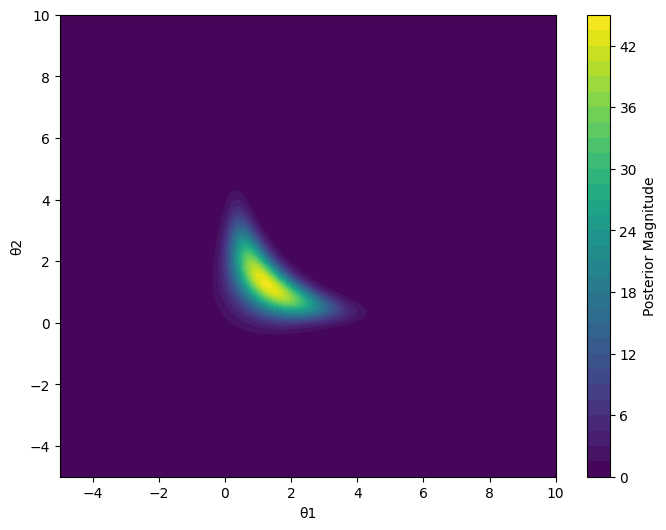

In [93]:
# Create a two-dimensional image of the posterior distribution using the example as illustrated by Aaron Reding during 10/2 OH

# Define ranges for theta1 and theta2
theta1_range = np.linspace(-5, 10, 600)
theta2_range = np.linspace(-5, 10, 600)

theta1_mesh, theta2_mesh = np.meshgrid(theta1_range, theta2_range)

def unnormalized_normal_pdf(theta1, theta2):
    return np.exp(-0.5 * (theta1**2 * theta2**2 + theta1**2 + theta2**2 - 2 * theta1 * theta2 - 4 * theta1 - 4 * theta2))

posterior = unnormalized_normal_pdf(theta1_mesh, theta2_mesh)

# Plotting
plt.figure(figsize = (8, 6))
bins = 40
plt.contourf(theta1_mesh, theta2_mesh, posterior, levels = bins, cmap = "viridis")
plt.colorbar(label = "Posterior Magnitude")
plt.xlabel("θ1")
plt.ylabel("θ2")
plt.show()

In [94]:
# Created the Metropolis model as illustrated in Unit 5.9 Weibull Lifetimes and during 10/2 OH by Aaron Reding
seed = 250
rng = np.random.default_rng(seed)
obs = 11000
burn = 1000
accepted = np.zeros(obs)

# Set the standard deviation using scale and covariance matrix
scale = 0.95 
cov_matrix = scale**2 * np.eye(2)

# Set initial values that will change throughout
θ1 = 3
θ2 = 3

# Create sample vectors with length obs
θ1_samples = np.zeros(obs)
θ2_samples = np.zeros(obs)

# Pre-generate 3 sets of random values
unif = rng.uniform(size = obs)
bivariate_normal_samples = rng.multivariate_normal([0, 0], cov_matrix, size=obs)
θ1_prop = bivariate_normal_samples[:, 0]
θ2_prop = bivariate_normal_samples[:, 1]

for i in tqdm(range(obs)):
    θ1_prop_current = θ1_prop[i] + θ1
    θ2_prop_current = θ2_prop[i] + θ2
    # Acceptance ratio
    ar = unnormalized_normal_pdf(θ1_prop_current, θ2_prop_current)/unnormalized_normal_pdf(θ1, θ2)
    rho = min(1, ar)
    
    if unif[i] < rho:
        θ1 = θ1_prop_current
        θ2 = θ2_prop_current
        accepted[i] = 1
    
    θ1_samples[i] = θ1
    θ2_samples[i] = θ2

print(f"acceptance rate is {accepted.sum()/obs:.3f} when scale is {scale}")


  0%|          | 0/11000 [00:00<?, ?it/s]

acceptance rate is 0.402 when scale is 0.95


#### Part b

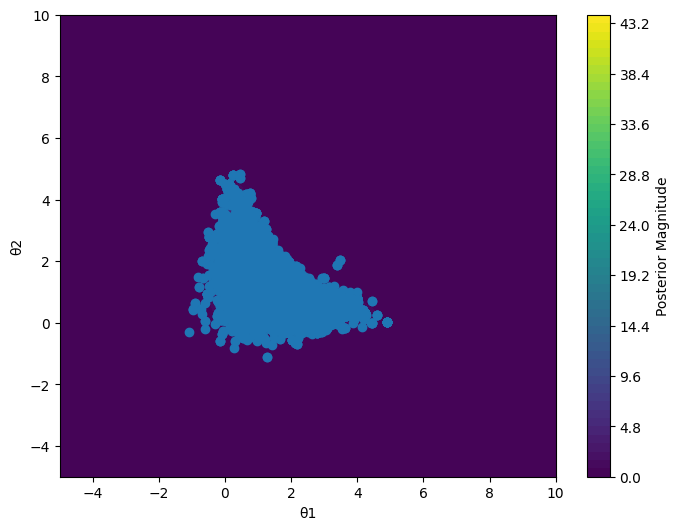

In [95]:
# Plotting samples on top of the two-dimensional graph
plt.figure(figsize = (8, 6))
plt.plot(θ1_samples, θ2_samples, "o")
bins = 60
plt.contourf(theta1_mesh, theta2_mesh, posterior, levels = bins, cmap = "viridis")
plt.colorbar(label = "Posterior Magnitude")
plt.xlabel("θ1")
plt.ylabel("θ2")
plt.show()

#### Part c

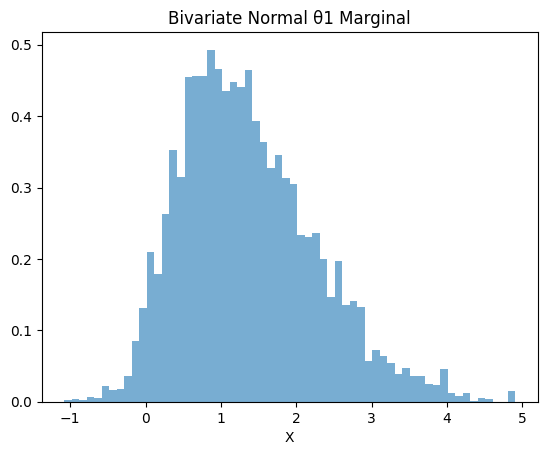

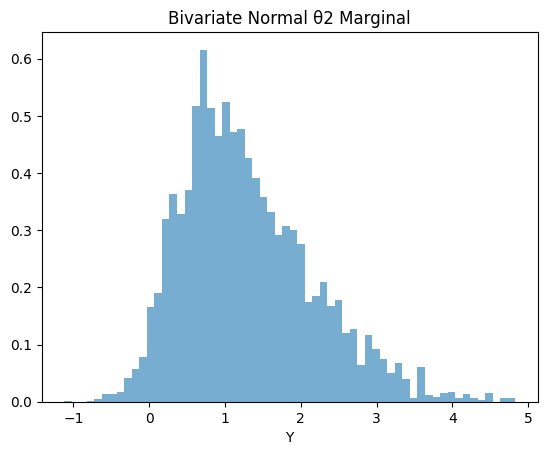

In [96]:
# Plot marginal densities of θ1 and θ2 using samples
plt.hist(θ1_samples, bins=bins, density=True, alpha=0.6)
plt.title("Bivariate Normal θ1 Marginal")
plt.xlabel("X")
plt.show()

plt.hist(θ2_samples, bins=bins, density=True, alpha=0.6)
plt.title("Bivariate Normal θ2 Marginal")
plt.xlabel("Y")
plt.show()

#### Part d

In [97]:
# 95% equi-tailed credible set for θ1
θ1_lower_bound = np.percentile(θ1_samples[burn:], 2.5)
θ1_upper_bound = np.percentile(θ1_samples[burn:], 97.5)
print(f"95% credible interval for θ1: [{θ1_lower_bound}, {θ1_upper_bound}]")

# 95% equi-tailed credible set for θ2
θ2_lower_bound = np.percentile(θ2_samples[burn:], 2.5)
θ2_upper_bound = np.percentile(θ2_samples[burn:], 97.5)
print(f"95% credible interval for θ2: [{θ2_lower_bound}, {θ2_upper_bound}]")


95% credible interval for θ1: [-0.03230513237726603, 3.4443348780372656]
95% credible interval for θ2: [0.0017400712293841325, 3.3074390084104115]


### Question 2

#### Part a
Please see the accompanying report for finding the full conditionals of θ1, θ2, and $ν^2$. Below we implement Gibbs sampling to generate samples of these parameters.

In [98]:
from scipy.stats import invgamma

# Implement Gibbs sampling as illustrated in Unit 5.11 Normal-Cauchy Gibbs Sampler by Aaron Reding
rng = np.random.default_rng(1)

obs = 100000
burn = 1000
y = 1.2
r = 11  # Shape parameter in inverse-gamma

# Set initial guesses
θ1 = 1
θ2 = 1
ν2 = 1

θ1_samples = np.zeros(obs)
θ2_samples = np.zeros(obs)
ν2_samples = np.zeros(obs)

randn = rng.standard_normal(obs)

for i in tqdm(range(obs)):
    d = 1 + ν2**(-1)
    new_θ1 = (y - θ2)/d + np.sqrt(1/d) * randn[i]
    new_θ2 = (y - new_θ1)/d + np.sqrt(1/d) * randn[i]

    lam = (new_θ1**2 + new_θ2**2 + 20)/2
    new_ν2 = invgamma.rvs(a = r, scale = lam, size = 1)[0]

    θ1, θ2, ν2 = new_θ1, new_θ2, new_ν2

    θ1_samples[i] = θ1
    θ2_samples[i] = θ2
    ν2_samples[i] = ν2

θ1_burnt = θ1_samples[burn: ]
θ2_burnt = θ2_samples[burn: ]
ν2_burnt = ν2_samples[burn: ]

  0%|          | 0/100000 [00:00<?, ?it/s]

#### Part b

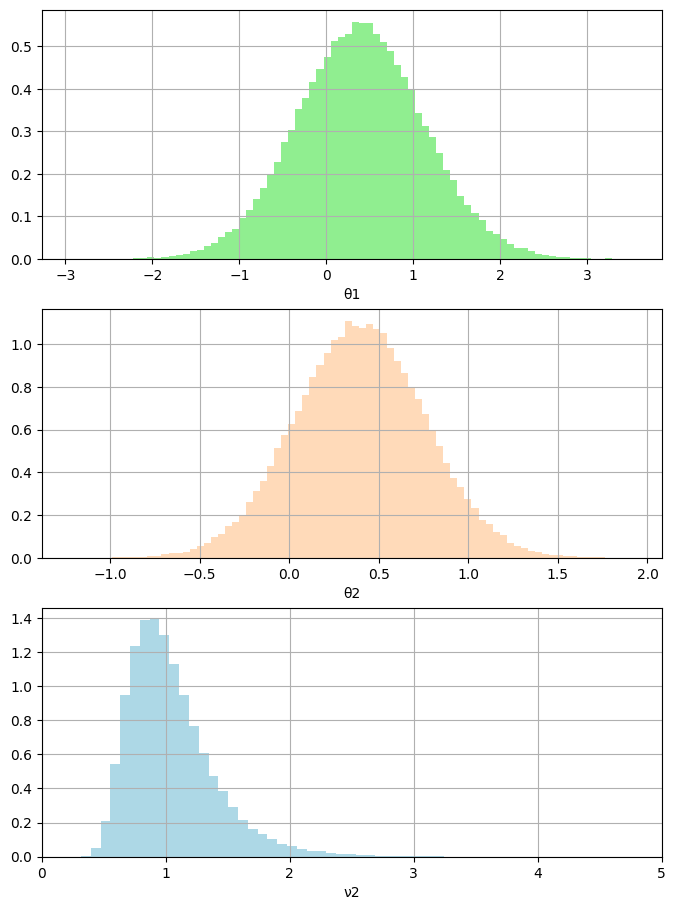

In [99]:
# Plot the marginal posterior densities
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 11))

ax1.grid(True)
ax1.hist(θ1_burnt, color="lightgreen", density=True, bins=80)
ax1.set_xlabel("θ1")

ax2.grid(True)
ax2.hist(θ2_burnt, color="peachpuff", density=True, bins=80)
ax2.set_xlabel("θ2")

ax3.grid(True)
ax3.hist(ν2_burnt, color="lightblue", density=True, bins=80)
ax3.set_xlabel("ν2")
ax3.set_xlim(0, 5)

plt.show()

In [100]:
#95% credit set for θ1
θ1_lower_bound = np.percentile(θ1_burnt, 2.5) 
θ1_upper_bound = np.percentile(θ1_burnt, 97.5) 
print(f"95% credible interval for θ1: [{θ1_lower_bound}, {θ1_upper_bound}]")

#95% credit set for θ2
θ2_lower_bound = np.percentile(θ1_burnt, 2.5) 
θ2_upper_bound = np.percentile(θ2_burnt, 97.5) 
print(f"95% credible interval for θ2: [{θ2_lower_bound}, {θ2_upper_bound}]")

#95% credit set for ν2
ν2_lower_bound = np.percentile(ν2_burnt, 2.5) 
ν2_upper_bound = np.percentile(ν2_burnt, 97.5) 
print(f"95% credible interval for ν2: [{ν2_lower_bound}, {ν2_upper_bound}]")

95% credible interval for θ1: [-1.029614481543578, 1.8412557649502928]
95% credible interval for θ2: [-1.029614481543578, 1.1094401503763076]
95% credible interval for ν2: [0.5638430600514353, 1.9258743549637616]


In [101]:
print(f"{np.mean(θ1_burnt)=}")
print(f"{np.var(θ1_burnt)=}")
print(f"{np.mean(θ2_burnt)=}")
print(f"{np.var(θ2_burnt)=}")
print(f"{np.mean(ν2_burnt)=}")
print(f"{np.var(ν2_burnt)=}")

np.mean(θ1_burnt)=0.3951453499927724
np.var(θ1_burnt)=0.5343055853655151
np.mean(θ2_burnt)=0.3956338931024064
np.var(θ2_burnt)=0.13269355302483976
np.mean(ν2_burnt)=1.0484718779408853
np.var(ν2_burnt)=0.12594284486144686


#### Part c

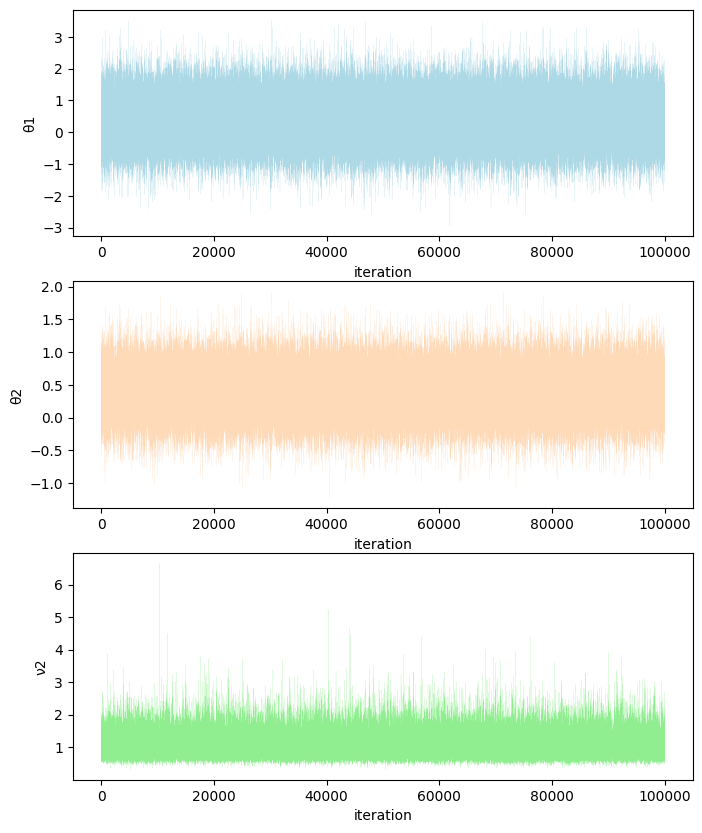

In [102]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 10))

ax1.plot(range(obs), θ1_samples, color="lightblue", linewidth=0.1)
ax1.set_ylabel("θ1")
ax1.set_xlabel("iteration")

ax2.plot(range(obs), θ2_samples, color="peachpuff", linewidth=0.1)
ax2.set_ylabel("θ2")
ax2.set_xlabel("iteration")

ax3.plot(range(obs), ν2_samples, color="lightgreen", linewidth=0.1)
ax3.set_ylabel("ν2")
ax3.set_xlabel("iteration")

plt.show()